# Training a model to identify different sports

In this notebook, we aim to build a deep learning model which will classify images according to what sport is being played in them. We have 8 different types of sports - Badminton, Bocce, Croquet, Polo, Rock Climbing, Rowing, Sailing, and Snowboarding.

We will build two models-  
1. **CNN with the basic architecture** - Conv2D layers, Max Pooling Layers, followed by Dense Layers.
2. **CNN with Transfer Learning** - Weights from a pre-trained model, followed by a Dense Layer for our problem.

Imports

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import to_categorical

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Image & Batch Size

We will resize all images to 224 x 224, and our batch size will be 32.

In [2]:
IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 32

### Dataset Information

The dataset contains 1558 images, which will be split into training and validaition sets. 80% of the images will be used to train the model, and the other 20% will be used for validation.

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Dell/Downloads/Neural Network/project2/FINAL PROJECT/Train2",
    validation_split=0.2,
    subset="training",
    label_mode = "categorical",
    seed=1005,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Dell/Downloads/Neural Network/project2/FINAL PROJECT/Train2",
    validation_split=0.2,
    subset="validation",
    label_mode = "categorical",
    seed=1005,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

#store class names
class_names = train_ds.class_names

Found 1558 files belonging to 8 classes.
Using 1247 files for training.
Found 1558 files belonging to 8 classes.
Using 311 files for validation.


In [4]:
#prefetch data to speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Visualize Training Data

Let us take a look at some of our training data.

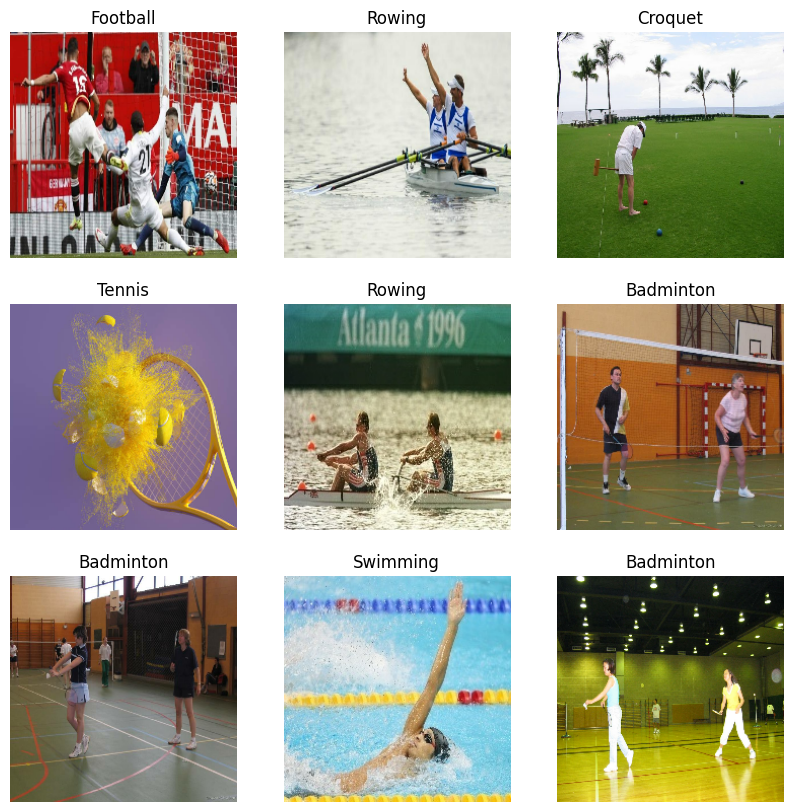

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(8):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

## Approach 1 - Basic CNN

The first two layers we are using are responsible for rescaling and data augmentation. Within the data augmentation layer, we are using a horizontal flip and a random zoom. The augmentation ensures that the training data is reshaped and re-fed into the model, thus increasing the number of examples our model is learning on. Ultimately, this helps the model generalize better.  

For the learning itself, our model has 3 Convolution layers, each followed by a Max Pool layer. After 3 sets of convolution layers, we incorporate a dropout layer, a dense layer with 128 neurons, and finally a dense layer with 8 neurons - which correspond to the 8 sports that we want to predict. Kindly note that we will be using the **relu** activation throughout.

In [7]:
# model = Sequential()

# # Add a convolutional layer with 32 filters and a 3x3 kernel
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))

# # Add a max pooling layer with a 2x2 pool size
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Add a convolutional layer with 64 filters and a 3x3 kernel
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# # Add a max pooling layer with a 2x2 pool size
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten the feature maps
# model.add(Flatten())

# # Add a fully connected layer with 128 units
# model.add(Dense(128, activation='relu'))

# # Add a fully connected layer with the number of classes
# model.add(Dense(8, activation='softmax'))


In [8]:
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Fit the model to the training data
# model.fit(train_ds, val_ds, epochs=10, batch_size=32)


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomZoom(0.10),
    ]
)

num_classes = 8

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Optimization,  Learning Parameters, Loss & Metrics

**Optimizer**: We will be using the basic stochastic gradient descent (SGD) optimizer with a learning rate of 0.005 and a momentum of 0.9.  
**Loss**: We will use Categorical Crossentropy, which means that our response is coded into one-hot vectors.  
**Metrics**: While we will be monitoring loss, we want to take a look at accuracy as well.

In [10]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

### Fitting the Model

We have around 6.4 million parameters to train, so it might be a little slow. Let us start off with 20 epochs to get a feel for how well our model is learning.

In [12]:
epochs = 15

trialOne = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/15
39/39 [==============================] - 200s 5s/step - loss: 2.0072 - accuracy: 0.1877 - val_loss: 1.8798 - val_accuracy: 0.2605
Epoch 2/15
39/39 [==============================] - 97s 2s/step - loss: 1.7277 - accuracy: 0.3833 - val_loss: 1.5517 - val_accuracy: 0.4855
Epoch 3/15
39/39 [==============================] - 98s 3s/step - loss: 1.5059 - accuracy: 0.5301 - val_loss: 1.4055 - val_accuracy: 0.5884
Epoch 4/15
39/39 [==============================] - 101s 3s/step - loss: 1.3897 - accuracy: 0.5974 - val_loss: 1.3169 - val_accuracy: 0.6334
Epoch 5/15
39/39 [==============================] - 104s 3s/step - loss: 1.2362 - accuracy: 0.6568 - val_loss: 1.3719 - val_accuracy: 0.5949
Epoch 6/15
39/39 [==============================] - 106s 3s/step - loss: 1.1089 - accuracy: 0.7394 - val_loss: 1.2894 - val_accuracy: 0.6174
Epoch 7/15
39/39 [==============================] - 102s 3s/step - loss: 1.0155 - accuracy: 0.7827 - val_loss: 1.1988 - val_accuracy: 0.6752
Epoch 8/15
39/3

### Visualize Loss Plots

Visualizing the loss vs. iterations plots tells us if our model is overfitting or not, and gives us an overall idea of how fast the model is learning.

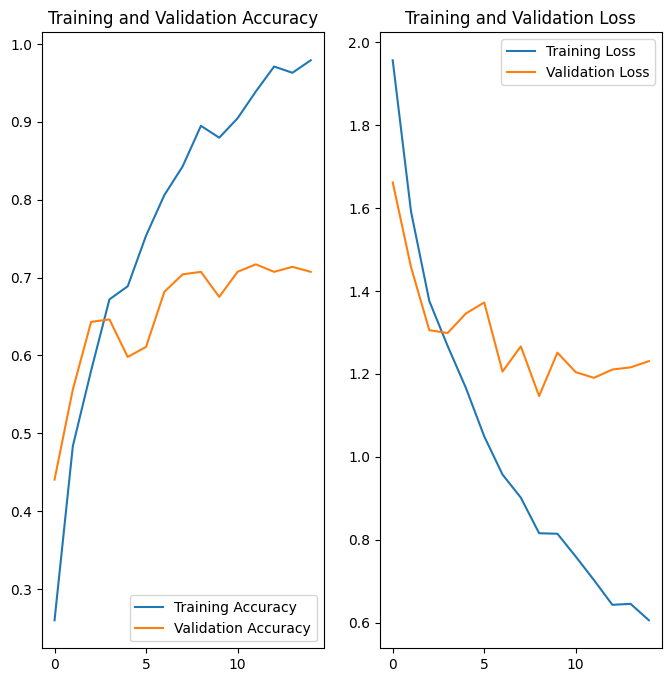

In [42]:

acc = trialOne.history['accuracy']
val_acc = trialOne.history['val_accuracy']

loss = trialOne.history['loss']
val_loss = trialOne.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion for Approach 1

From the plots above, we see that validation accuracy and loss have started to plateau around iteration 8. The training loss continued to decline all the way to iteration 20, which means our model is able to learn but is not able to generalize well.

After 15 epochs:

**Training Loss** : 0.5788   
**Training Accuracy** : 0.9920  

**Validation Loss** : 1.1359 
**Validation Accuracy** : 0.7395 

## Approach 2 - Transfer Learning

Once again, the first two layers we are using are responsible for rescaling and data augmentation. We are using the same data augmentation process as last time.  

For the learning, our model first reads the pre-trained weights, after which we have a dropout layer, followed by a dense layer with 8 neurons - which correspond to the 8 sports that we want to predict. This time, we expect the number of trainable parameters to be much lesser than in Approach 1.  

Even though the model below looks simple, we must keep in mind that the pre-trained weights bring in a lot of "experience" when it comes to the task at hand. We hypothesize that this model will outperform the Basic CNN model (Approach 1).

In [14]:
module_selection = ("mobilenet_v2_100_224", IMAGE_LEN) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomZoom(0.10),
    ]
)

num_classes = 8
do_fine_tuning = False

model1 = Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Optimization,  Learning Parameters, Loss & Metrics

**Optimizer**: We will be using the basic stochastic gradient descent (SGD) optimizer with a learning rate of 0.005 and a momentum of 0.9.  
**Loss**: We will use Categorical Crossentropy, which means that our response is coded into one-hot vectors.  
**Metrics**: While we will be monitoring loss, we want to take a look at accuracy as well.

In [16]:
model1.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [17]:
model1.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


### Fitting the Model

This time, we have around 2.2 million parameters in the model, but since we are using pre-trained weights, only about 10,000 of them are trainable. We might not need as many epochs as we did earlier, so let us start with 5 epochs to gauge how well our model learns.

In [18]:
epochs = 5

trialTwo = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/5


39/39 [==============================] - 102s 2s/step - loss: 1.1256 - accuracy: 0.7506 - val_loss: 0.8266 - val_accuracy: 0.9164
Epoch 2/5
39/39 [==============================] - 87s 2s/step - loss: 0.7251 - accuracy: 0.9423 - val_loss: 0.7195 - val_accuracy: 0.9325
Epoch 3/5
39/39 [==============================] - 95s 2s/step - loss: 0.6424 - accuracy: 0.9631 - val_loss: 0.6959 - val_accuracy: 0.9260
Epoch 4/5
39/39 [==============================] - 116s 3s/step - loss: 0.6111 - accuracy: 0.9783 - val_loss: 0.6974 - val_accuracy: 0.9228
Epoch 5/5
39/39 [==============================] - 95s 2s/step - loss: 0.6091 - accuracy: 0.9727 - val_loss: 0.6698 - val_accuracy: 0.9389


### Visualize Loss Plots

Visualizing the loss vs. iterations plots tells us if our model is overfitting or not, and gives us an overall idea of how fast the model is learning.

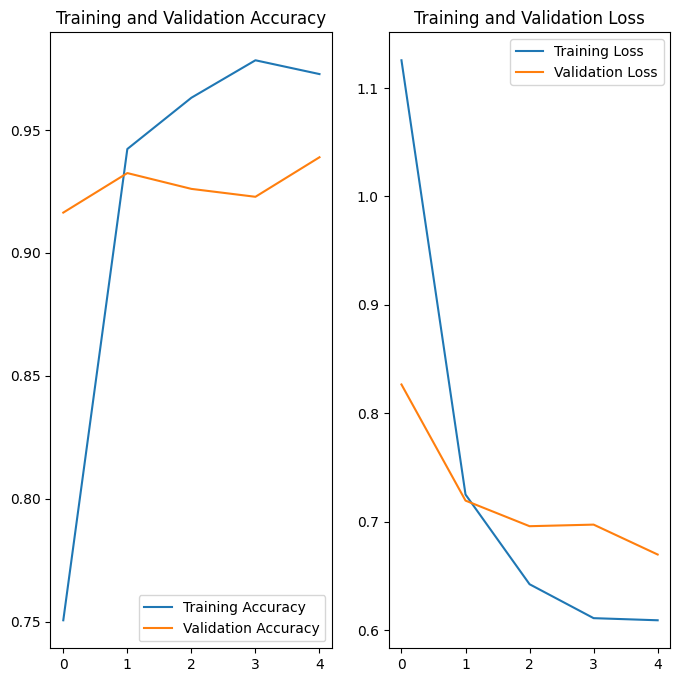

In [19]:
acc = trialTwo.history['accuracy']
val_acc = trialTwo.history['val_accuracy']

loss = trialTwo.history['loss']
val_loss = trialTwo.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion for Approach 2

After just 5 epochs, the validation loss is extremely low, and the validation accuracy is extremely high. The "experience" that the pre-trained weights have brought has made our model much more robust and accurate.  

After 5 epochs:

**Training Loss** : 0.6349    
**Training Accuracy** : 0.9647  

**Validation Loss** : 0.6782   
**Validation Accuracy** : 0.9496  

## Predicting on Test Data

Finally, let us use our transfer learning model to test on completely new data. The model has not seem this data before. The test dataset contains 16 images - 2 from each sport. We will look at every single one of them along with their predictions.

In [20]:
Test = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Dell/Downloads/Neural Network/project2/FINAL PROJECT/Test2",
    shuffle=True,
    label_mode = "categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 16 files belonging to 8 classes.


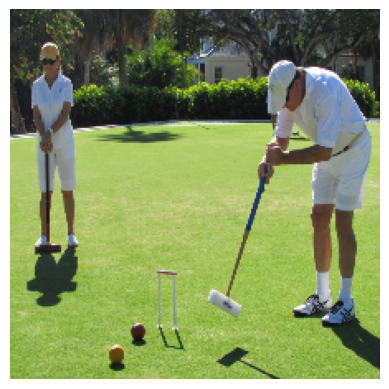

1/1 [==============================] - 3s 3s/step
True label: Croquet
Predicted label: Croquet


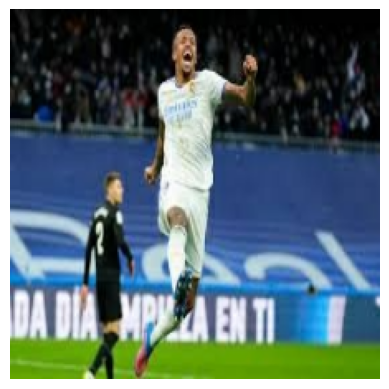

1/1 [==============================] - 0s 179ms/step
True label: Football
Predicted label: Football


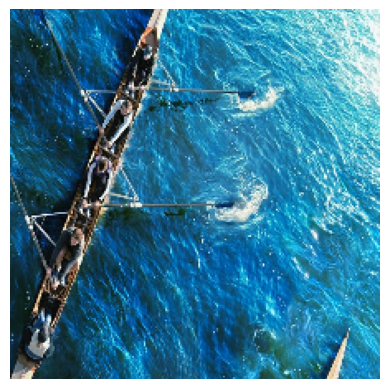

1/1 [==============================] - 0s 50ms/step
True label: Rowing
Predicted label: Tennis


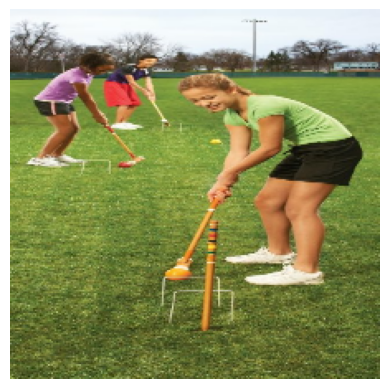

1/1 [==============================] - 0s 69ms/step
True label: Croquet
Predicted label: Croquet


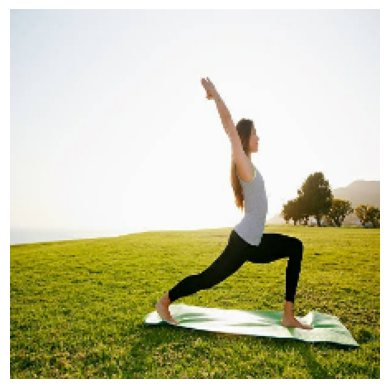

1/1 [==============================] - 0s 60ms/step
True label: Yoga
Predicted label: Football


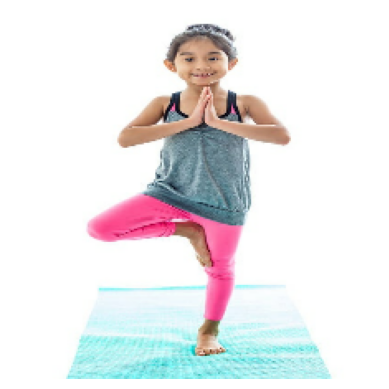

1/1 [==============================] - 0s 89ms/step
True label: Yoga
Predicted label: Yoga


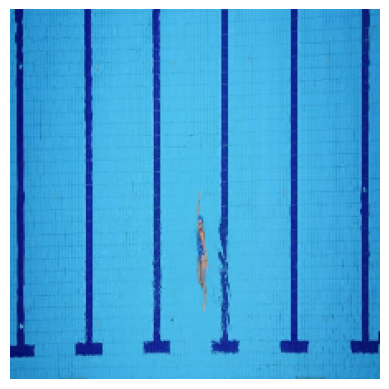

1/1 [==============================] - 0s 53ms/step
True label: Swimming
Predicted label: Swimming


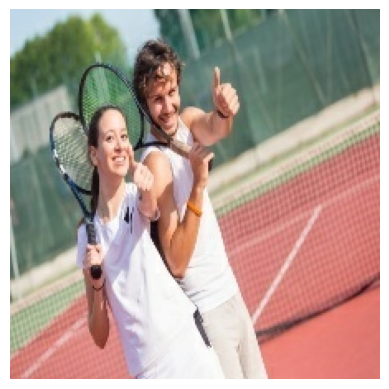

1/1 [==============================] - 0s 160ms/step
True label: Tennis
Predicted label: Tennis


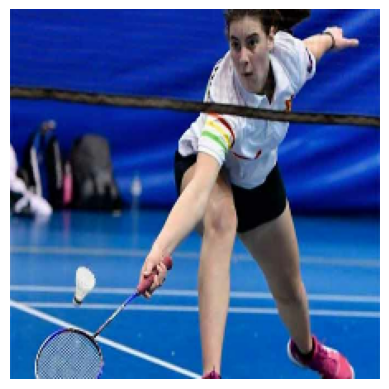

1/1 [==============================] - 0s 67ms/step
True label: Badminton
Predicted label: Swimming


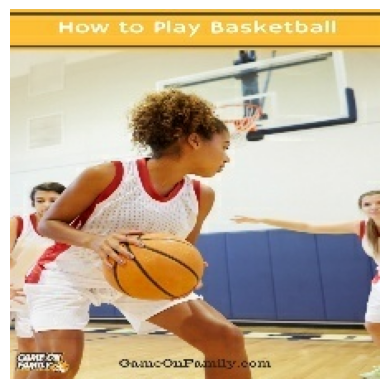

1/1 [==============================] - 0s 83ms/step
True label: Basketball
Predicted label: Swimming


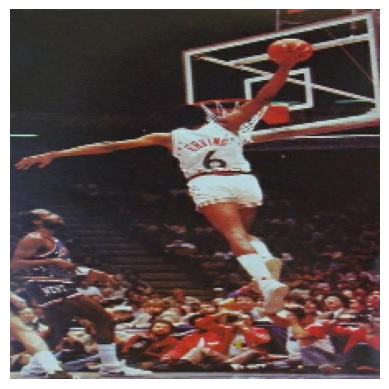

1/1 [==============================] - 0s 58ms/step
True label: Basketball
Predicted label: Basketball


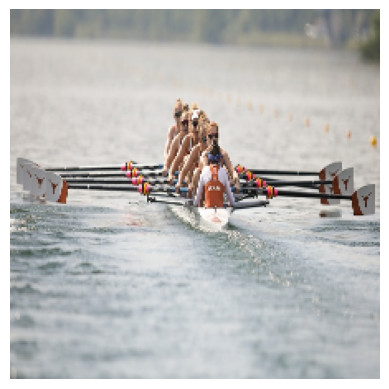

1/1 [==============================] - 0s 52ms/step
True label: Rowing
Predicted label: Rowing


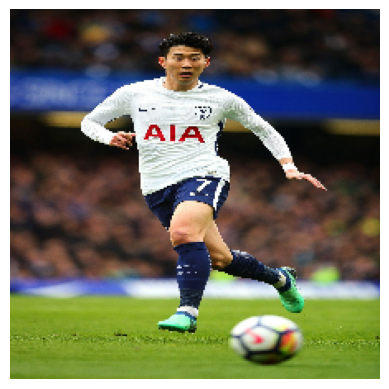

1/1 [==============================] - 0s 115ms/step
True label: Football
Predicted label: Football


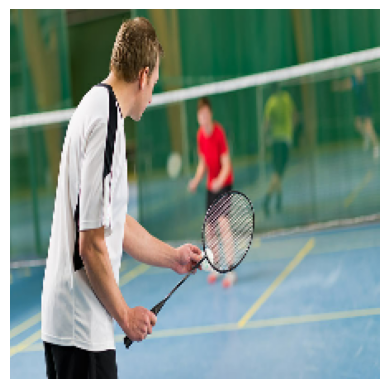

1/1 [==============================] - 0s 193ms/step
True label: Badminton
Predicted label: Tennis


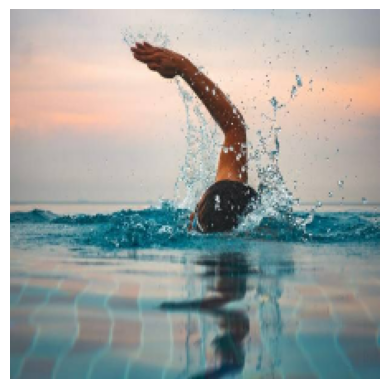

1/1 [==============================] - 0s 124ms/step
True label: Swimming
Predicted label: Swimming


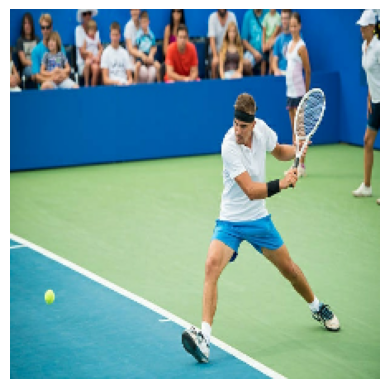

1/1 [==============================] - 0s 89ms/step
True label: Tennis
Predicted label: Tennis


In [21]:
def get_class_string_from_index(index):
    return Test.class_names[index]
        
for images, labels in Test.take(1):
    for i in range(16):
        plt.imshow(images[i].numpy().astype("uint8"))
        true_index = np.argmax(labels[i])
        plt.axis("off")
        plt.show()
        
        prediction_scores = model.predict(np.expand_dims(images[i], axis=0))
        predicted_index = np.argmax(prediction_scores)
        print("True label: " + get_class_string_from_index(true_index))
        print("Predicted label: " + get_class_string_from_index(predicted_index))

Our model predicted every single one of them correctly!